In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 25.80 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Checking out files: 100% (56/56), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=28255 sha256=4253d726c3e48c417d7af14ee8938ac91691e43b1a532907f97cad69044338e0
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [2]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [11]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"


class Discriminator(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.ReLU(),
        )

        self.linear = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.reshape(x.shape[0], -1)
        return self.linear(out)


class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),  # 1 x 28 x 28 -> 32 x 28 x 28
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),  # -> 64 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),  # -> 128 x 7 x 7
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 2, 1),  # -> 128 x 4 x 4
            nn.ReLU(),
        )
        self.linear = nn.Linear(4 * 4 * 128, latent_dim)

    def forward(self, x):
        out = self.conv(x)
        out = out.reshape(x.shape[0], -1)
        return self.linear(out)


class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(latent_dim, 4 * 4 * 128), nn.ReLU())

        self.convt = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        out = self.linear(x)
        out = out.reshape(-1, 128, 4, 4)
        return self.convt(out)


class ContextEncoder(nn.Module):
    def __init__(self, latent_dim=128, crop_size=(14, 14)):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.discriminator = Discriminator(latent_dim)

        self.crop_size = crop_size
        self.eps = 1e-8

    def mask(self, img):
        crop_h, crop_w = self.crop_size
        batch_size, _, h, w = img.shape

        x = np.random.randint(0, h - crop_h, size=batch_size)
        y = np.random.randint(0, w - crop_w, size=batch_size)

        mask = torch.zeros_like(img)
        for img_mask, h, w in zip(mask, x, y):
            img_mask[:, h : h + crop_h, w : w + crop_w] = 1.0

        return mask.to(device)

    def recon_loss(self, x, recon, mask):
        recon_loss = (mask * F.mse_loss(recon, x, reduction="none")).reshape(x.shape[0], -1).mean(dim=1)
        with torch.no_grad():
            fake = self.discriminator(recon)

        f_loss = F.binary_cross_entropy(fake, torch.ones_like(fake, device=device))

        ed_loss = recon_loss + f_loss

        return recon_loss.mean(), ed_loss.mean()

    def adversarial_loss(self, batch, recon):

        real = self.discriminator(batch)
        fake = self.discriminator(recon)

        loss_real = F.binary_cross_entropy(real, torch.ones_like(real, device=device))
        loss_fake = F.binary_cross_entropy(fake, torch.zeros_like(fake, device=device))

        loss = loss_real + loss_fake
        return loss.mean()

    def reconstruct(self, x):
        return self.decoder(self.encoder(x))

    def _step(self, batch):
        mask = self.mask(batch)
        recon = self.reconstruct((1 - mask) * batch)

        recon_loss, ed_loss = self.recon_loss(batch, recon, mask)
        d_loss = self.adversarial_loss(batch, recon.detach())

        return recon_loss, ed_loss, d_loss

    def fit(self, trainloader, epochs=10, lr=1e-3, discriminator_update_rate=10):
        encoder_optim = Adam(self.encoder.parameters(), lr=lr)
        decoder_optim = Adam(self.decoder.parameters(), lr=lr)
        discriminator_optim = Adam(self.discriminator.parameters(), lr=lr)

        recon_losses = []
        adversarial_losses = []

        iteration = 0
        for _ in range(epochs):
            for batch in trainloader:
                iteration += 1
                batch = batch[0].float().to(device)

                recon_loss, ed_loss, d_loss = self._step(batch)

                encoder_optim.zero_grad()
                decoder_optim.zero_grad()
                ed_loss.backward()
                encoder_optim.step()
                decoder_optim.step()

                if (iteration + 1) % discriminator_update_rate == 0:
                    discriminator_optim.zero_grad()
                    d_loss.backward()
                    discriminator_optim.step()

                recon_losses.append(recon_loss.detach().cpu().numpy())
                adversarial_losses.append(d_loss.detach().cpu().numpy())

        return np.array(recon_losses), np.array(adversarial_losses)

    def examples(self, x):
        with torch.no_grad():
            self.eval()
            x = torch.tensor(x, dtype=torch.float32).to(device)
            mask = self.mask(x)
            x_curr = (1 - mask) * x
            x_rec = self.reconstruct(x_curr)
            out = np.vstack((x_curr.cpu().numpy(), x_rec.cpu().numpy(), x.cpu().numpy()))
            return out

In [12]:
def q1(train_data, test_data, epochs=20, batch_size=256, lr=1e-4, device="cuda"):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    
    
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model = ContextEncoder().to(device)
    recon_loss, adversarial_loss = model.fit(trainloader, epochs=epochs, lr=lr, discriminator_update_rate=10)
    
    testloader = DataLoader(test_data, batch_size=10, shuffle=True)
    for batch in testloader:
        examples = model.examples(batch[0])
        break
    
    return recon_loss, adversarial_loss, examples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


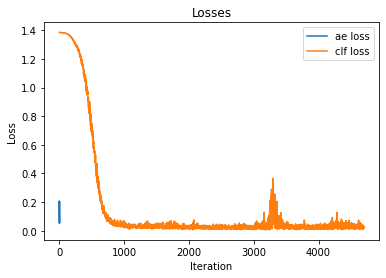

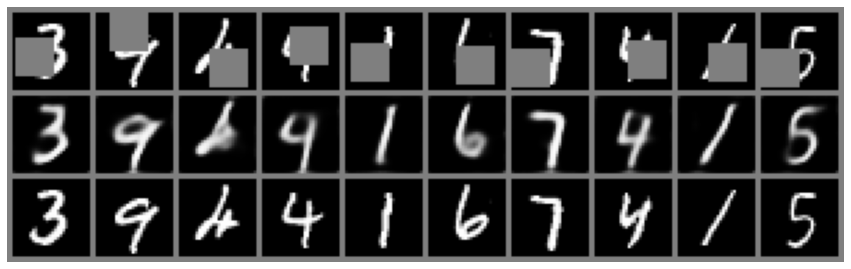

In [13]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [15]:
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms.functional import rotate


class NewDataset(Dataset):
    def __init__(self, data) -> None:
        super().__init__()

        self.data = data
        self.rotations = [0, 90, 180, 270]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        r = np.random.choice(len(self.rotations))
        return rotate(self.data[index][0], self.rotations[r]), r
    

class RNet(nn.Module):
    def __init__(self, hidden_dim=128) -> None:
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.ReLU(),
        )

        self.linear = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4),
        )

        self.rotations = [0, 90, 180, 270]
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        out = self.conv(x)
        return self.linear(out.reshape(x.shape[0], -1))

    def _step(self, batch):
        x, label = batch
        x = x.to(device)
        label = label.to(device)
        return self.criterion(self(x), label)

    def _get_accuracy(self, loader):
        accuracies = []
        with torch.no_grad():
            for batch in loader:
                x, label = batch
                x = x.to(device)
    
                y = torch.argmax(self(x), dim=1).cpu().numpy()
    
                accuracies.append(accuracy_score(label.cpu().numpy(), y))
    
            return np.mean(accuracies)

    def fit(self, trainloader, epochs=10, lr=1e-4):
        losses = []
        accuracy = [self._get_accuracy(trainloader)]

        optim = Adam(self.parameters(), lr=lr)

        for _ in range(epochs):
            for batch in trainloader:
                loss = self._step(batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss.detach().cpu().numpy())
            accuracy.append(self._get_accuracy(trainloader))
        return np.array(losses), np.array(accuracy)

In [16]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    dset = NewDataset(train_data)
    trainloader = DataLoader(dset, batch_size=256, shuffle=True)
    
    model = RNet().to(device)
    losses, accs = model.fit(trainloader)
    
    return losses, accs

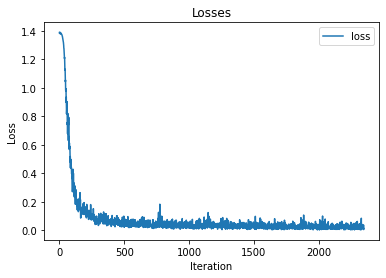

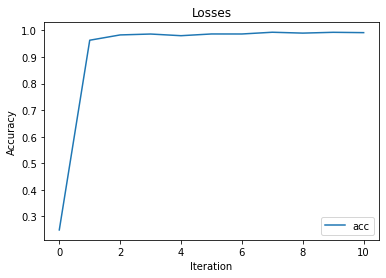

In [17]:
q2_results(q2)